### Exercise 3: The Runaway Neato (Implementation Problem)
A Neato is on the loose in the MAC, and we need to estimate where it has gone! We will make a very simple assumption that we can represent our world as a 1D system. We will set up a simple simulation of this world, where the robot’s pose is controlled by its velocity and process noise, and noisy observations of this pose can be directly observed:

In [21]:
import matplotlib.pyplot as plt
import math
import numpy as np

def simulate_realworld_neato(sensor_var, process_var, vel=1.0, step=1, dt=1.):
    """Simulates the movement of a Neato and measurement in the world.
    Input: 
        sensor_var
        process_var
        vel (float): velocity of the bot
        step (int): number of simulation snapshots
        dt (float): time delta between simulation snapshots
    Return:
        xs (array(float)): real positions
        zs (array(float)): observed positions
    """
    x = 0.  # initial position
    sensor_std = math.sqrt(sensor_var)  # compute sensor standard deviation from variance
    process_std = math.sqrt (process_var)  # compute process standard deviation from variance
    xs, zs = [] ,[]
    for _ in range(step):
        v = vel + (np.random.randn() * process_std)
        x += v * dt  # simple velocity based update
        xs.append(x)
        zs.append(x + np.random.randn() * sensor_std)  # noise corrupted observation
    return np.array(xs), np.array(zs)

def kalman_filter(zs, dt, r_var, q_var):
    x = np.array([[0, 1]]).T
    F = np.array([[1, dt],[0, 1]])
    H = np.array([[1, 0]])
    
    R = [[r_var]]
    P = np.diag([2.5, 1.5])

    Q_FACTOR = 0.01
    Q = np.diag([q_var, q_var]) * Q_FACTOR
    
    xp, cov = [x], [P]
    for z in zs:
        # Predict
        x = F @ x
        P = F@P@F.T + Q
        
        # Update
        S = H@P@H.T + R
        y = z - H@x
        K = P@H.T@np.linalg.inv(S)

        # Updated state and covariance
        x += K @ y
        P = P - K @ H @ P

        xp.append(x)
        cov.append(P)
    return np.array(xp), np.array(cov)

I chose to implement a regular Kalman Filter rather than an Extended Kalman Filter, since the system is **linear**. The state of the system is represented as a 2D vector, where the first element is the position of the Neato and the second element is its velocity. The state transition model can defined using newtonian physics where $x$ is the position, $\dot{x}$ is the velocity, $\Delta t$ is the time step.  

$$\begin{bmatrix} x \\ \dot{x} \end{bmatrix} = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ \dot{x} \end{bmatrix}$$

And since we are only measuring the position of the Neato, the observation model is simply  

$$z = \begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} x \\ \dot{x} \end{bmatrix}$$

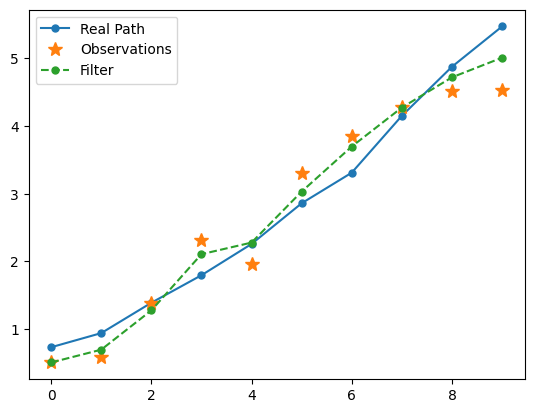

In [14]:
dt = 0.5
r_var = 0.2
q_var = 0.1
step = 10

xs, zs = simulate_realworld_neato(r_var, q_var, vel=1., step=step, dt=dt)
xp, cov = kalman_filter(zs, dt, r_var, q_var)
plt.plot(xs, marker=".", ms=10, label="Real Path")
plt.plot(zs, linestyle="", marker="*", ms=10, label="Observations")
plt.plot(xp[:, 0], linestyle="--", marker=".", ms=10, label="Filter")
plt.legend()
plt.show()

In [20]:
print("Intial P: \n" ,cov[0] , "\nFinal P: \n" , cov[-1])

Intial P: 
 [[0.1869961  0.04876463]
 [0.04876463 1.31813264]] 
Final P: 
 [[0.0703729  0.02316668]
 [0.02316668 0.01359755]]


**1. How does the process covariance change with each iteration of the filter? What would the off-diagonal values indicate?**  

The covariance $P$ decreases with each iteration of the filter, since we are getting more information about the system with each observation. The off-diagonal values indicate the correlation between the position and velocity estimates.

**2. What impact does $R$ have on the quality of the Neato position estimate? What about $Q$?**  

$R$ and $Q$ play a crucial role in determining the Kalman Gain of the filter, which determines whether the filter should rely more on our prediction or the observations. If $R$ is large, then the filter will rely more on our prediction, and if $Q$ is large, then the filter will rely more on our observations.

**3. If you were to add a noisy measurement of velocity at each timestep, what would need to be redefined about your model? How different would you expect the filter performance to be?**  

If there was a noisy measurement of velocity at each timestep, that would require a change in the observation model. Since we are measuring 2 different values instead of 1, the observation model would need to be redefined as follows:

$$ \begin{bmatrix} z_x \\ z_{\dot{x}} \end{bmatrix} = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ \dot{x} \end{bmatrix}$$

This would also require a change in the observation noise covariance matrix $R$, which would now need to be a 2x2 matrix instead of a scalar. 

$$ \begin{bmatrix} \sigma_{z_x}^2 & 0 \\ 0 & \sigma_{z_{\dot{x}}}^2 \end{bmatrix} $$

The performance of the filter would likely improve, since we have no hidden states about the system at each timestep, but it would also depend heavily on the quality of the velocity measurements and the amount of noise in those measurements.